<a href="https://colab.research.google.com/github/lyj18/vae/blob/master/Study_VAE_embedding_yijing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# load all libaries
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure

print(tf.__version__)

1.14.0


In [0]:
# import data - MNIST
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
print("Training set is of size: {}".format(x_train.shape))
print("Test set is of size: {}".format(x_test.shape))
print("A MNIST image is of size: {}".format(x_train[0].shape))

Training set is of size: (60000, 28, 28)
Test set is of size: (10000, 28, 28)
A MNIST image is of size: (28, 28)


In [0]:
# Normalise the data
x_train, x_test = x_train / 255.0, x_test / 255.0
n_train = x_train.shape[0]
n_test = x_test.shape[0]

In [0]:
# define a dataset and an iterator
batch_size = 256
code_size = 2
input_image = tf.placeholder(tf.float32, [None, 28, 28, 1])
input_label = tf.placeholder(tf.int32, [None, 1])
seed = tf.placeholder(tf.int64, shape=())
dataset = tf.data.Dataset.from_tensor_slices((input_image, input_label))
dataset = dataset.shuffle(buffer_size=60000, seed=seed)
dataset = dataset.repeat(8000)
dataset = dataset.batch(batch_size, drop_remainder=True)
iterator = dataset.make_initializable_iterator()
batch_image, batch_label = iterator.get_next()

code_input = tf.placeholder(tf.float32, [None, code_size])
is_code_input = tf.placeholder(tf.bool)

W0804 08:20:10.079547 139954779772800 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0804 08:20:10.086014 139954779772800 deprecation.py:323] From <ipython-input-5-99ba0349852f>:10: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


In [0]:
# build the auto-encoder model 
# encoder
with tf.variable_scope('encoder'):
    input = tf.layers.flatten(input_image)
    encoded = tf.nn.leaky_relu(tf.layers.dense(input, units=256, activation=None), alpha=0.1)
    encoded = tf.layers.dense(encoded, units=256, activation=tf.nn.relu)
    encoded_code = tf.layers.dense(encoded, units=code_size, activation=None)
    # change for VAE
    encoded_code_std = tf.layers.dense(encoded, units=code_size, activation=tf.nn.relu)
    encoded_code_std = encoded_code_std + 1e-6
    mvn = tfp.distributions.MultivariateNormalDiag(
                loc=encoded_code,
                scale_diag=encoded_code_std)
    encoded_code_sample = mvn.sample()
print("finish encoder: \n{}".format(encoded_code))
print("\n")
    
# decoder
with tf.variable_scope('decoder'):
    embedding = tf.cond(is_code_input, lambda: code_input, lambda: encoded_code_sample)
    decoded = tf.layers.dense(embedding, units=256, activation=tf.nn.relu)
    decoded = tf.layers.dense(decoded, units=256, activation=tf.nn.relu)
    decoded_image = tf.layers.dense(decoded, units=28*28, activation=tf.nn.sigmoid)
    decoded_image = tf.reshape(decoded_image, [-1, 28, 28, 1])
print("finish decoder: \n{}".format(decoded_image))
print('\n')
encoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "encoder")
decoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "decoder")
trainable_vars_AE = encoder_vars + decoder_vars

W0804 08:20:10.114154 139954779772800 deprecation.py:323] From <ipython-input-6-3330508f7d99>:2: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0804 08:20:10.409911 139954779772800 deprecation.py:323] From <ipython-input-6-3330508f7d99>:3: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0804 08:20:10.412282 139954779772800 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


finish encoder: 
Tensor("encoder/dense_2/BiasAdd:0", shape=(?, 2), dtype=float32)


finish decoder: 
Tensor("decoder/Reshape:0", shape=(?, 28, 28, 1), dtype=float32)




In [0]:
# Define the loss function
reconstruction_loss = tf.reduce_sum(tf.square(input_image - decoded_image), [1, 2, 3])
reconstruction_loss = tf.reduce_mean(reconstruction_loss)
reconstruction_loss = tf.squeeze(reconstruction_loss)

# KL loss
KL_loss=0.5 * (tf.reduce_sum(tf.square(encoded_code), 1)
              + tf.reduce_sum(tf.square(encoded_code_std), 1)
              - tf.reduce_sum(tf.log(tf.square(encoded_code_std)), 1)
              - code_size)
KL_loss=tf.reduce_mean(KL_loss)
KL_loss = tf.squeeze(KL_loss)

# ELBO loss
elbo = reconstruction_loss + KL_loss
elbo = tf.squeeze(elbo)

# Learning through gradient descent
lr = 0.001
opt = tf.train.AdamOptimizer(learning_rate=lr,
                             beta1=0.9,
                             beta2=0.95)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
gvs = opt.compute_gradients(elbo, var_list=trainable_vars_AE)
print('gvs: {}'.format(gvs))
capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
with tf.control_dependencies(update_ops):
    train_step = opt.apply_gradients(capped_gvs)
print("Reach the definition of loss")

saver = tf.train.Saver(max_to_keep=1, var_list=trainable_vars_AE)

gvs: [(<tf.Tensor 'gradients/encoder/dense/MatMul_grad/tuple/control_dependency_1:0' shape=(784, 256) dtype=float32>, <tf.Variable 'encoder/dense/kernel:0' shape=(784, 256) dtype=float32_ref>), (<tf.Tensor 'gradients/encoder/dense/BiasAdd_grad/tuple/control_dependency_1:0' shape=(256,) dtype=float32>, <tf.Variable 'encoder/dense/bias:0' shape=(256,) dtype=float32_ref>), (<tf.Tensor 'gradients/encoder/dense_1/MatMul_grad/tuple/control_dependency_1:0' shape=(256, 256) dtype=float32>, <tf.Variable 'encoder/dense_1/kernel:0' shape=(256, 256) dtype=float32_ref>), (<tf.Tensor 'gradients/encoder/dense_1/BiasAdd_grad/tuple/control_dependency_1:0' shape=(256,) dtype=float32>, <tf.Variable 'encoder/dense_1/bias:0' shape=(256,) dtype=float32_ref>), (<tf.Tensor 'gradients/encoder/dense_2/MatMul_grad/tuple/control_dependency_1:0' shape=(256, 2) dtype=float32>, <tf.Variable 'encoder/dense_2/kernel:0' shape=(256, 2) dtype=float32_ref>), (<tf.Tensor 'gradients/encoder/dense_2/BiasAdd_grad/tuple/contro

In [0]:
def plot_reconstructed_signal(x_test, y_test, reconstructed_image):
    # plot the reconstructed image for a shape
    fig, axs = plt.subplots(2, 10, figsize=(18, 4), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    axs = axs.ravel()
    for j in range(2):
        if j == 0:
            image_to_plot = x_test
        else:
            image_to_plot = np.squeeze(reconstructed_image)
        for i in range(10):
            axs[i+j*10].imshow(image_to_plot[i], cmap='gray')
            axs[i+j*10].grid(False)
            if j == 0: 
                axs[i+j*10].set_title("original {}".format(y_test[i]))
            else:
                axs[i+j*10].set_title("reconstructed {}".format(y_test[i]))
            axs[i+j*10].set_xticks([])
            axs[i+j*10].set_yticks([])
            # plt.tight_layout()
#         savefig(save_path + 'test_reconstructed_{}.pdf'.format(cur_epoch))
#         fig.clf()
#         plt.close()
    plt.show()

In [0]:
# start training
sess = tf.Session()
# initialise all variables
init = tf.group(tf.global_variables_initializer(),
                tf.local_variables_initializer())
sess.run(init)

At epoch 0, ELBO: training: 47.1278, test: 41.5258; 
reconstruction error: training: 44.5063, test: 38.7287; 
KL loss: training: 2.6215, test: 2.7971.


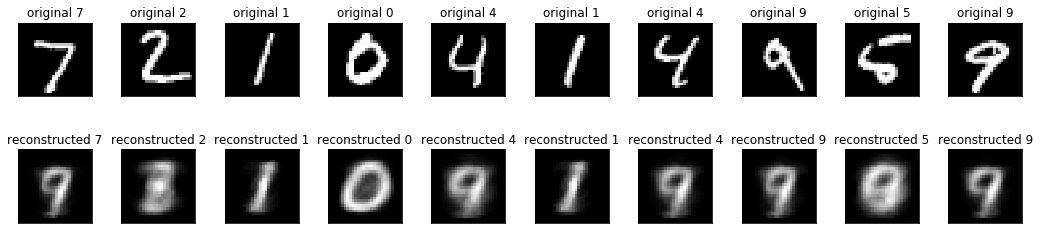

Model saved in path: ./VAE-model.ckpt
At epoch 1, ELBO: training: 42.4609, test: 40.8469; 
reconstruction error: training: 39.2485, test: 37.5289; 
KL loss: training: 3.2124, test: 3.3181.


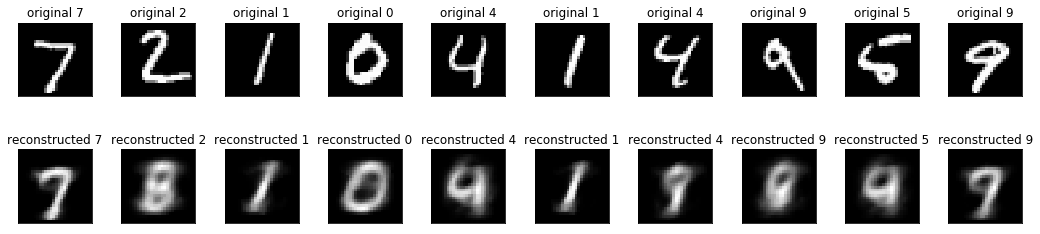

Model saved in path: ./VAE-model.ckpt
At epoch 2, ELBO: training: 41.4025, test: 39.9900; 
reconstruction error: training: 38.0792, test: 36.5822; 
KL loss: training: 3.3233, test: 3.4079.


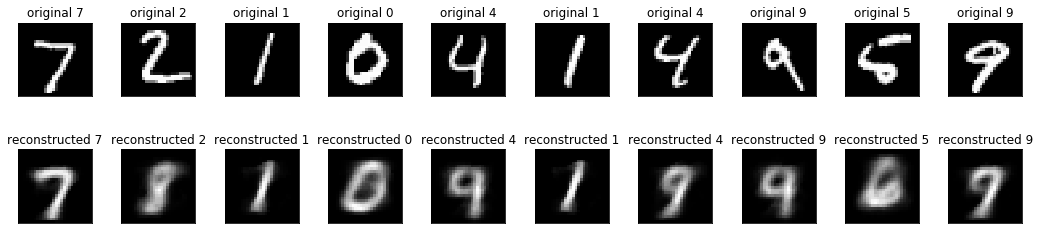

Model saved in path: ./VAE-model.ckpt
At epoch 3, ELBO: training: 39.9415, test: 37.7196; 
reconstruction error: training: 36.0105, test: 33.8145; 
KL loss: training: 3.9311, test: 3.9051.


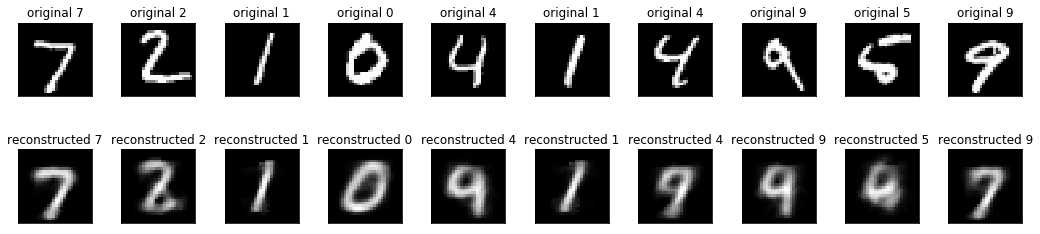

Model saved in path: ./VAE-model.ckpt
At epoch 4, ELBO: training: 39.0665, test: 37.0733; 
reconstruction error: training: 35.0031, test: 33.0913; 
KL loss: training: 4.0635, test: 3.9820.


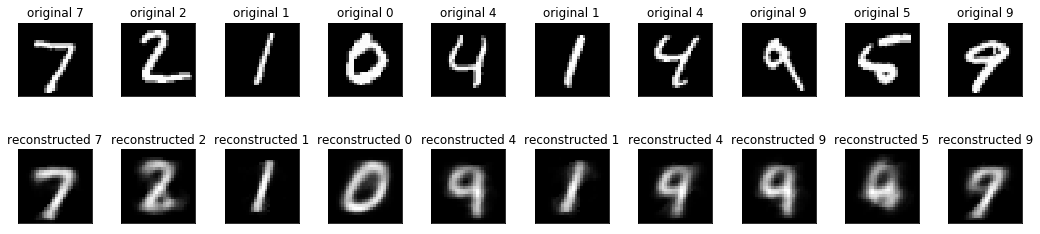

Model saved in path: ./VAE-model.ckpt
At epoch 5, ELBO: training: 38.8204, test: 37.6197; 
reconstruction error: training: 34.6914, test: 33.6238; 
KL loss: training: 4.1290, test: 3.9959.


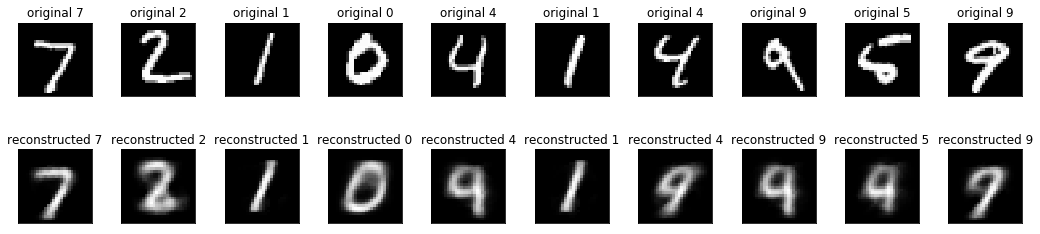

Model saved in path: ./VAE-model.ckpt
At epoch 6, ELBO: training: 37.9544, test: 35.5811; 
reconstruction error: training: 33.9439, test: 31.4831; 
KL loss: training: 4.0105, test: 4.0980.


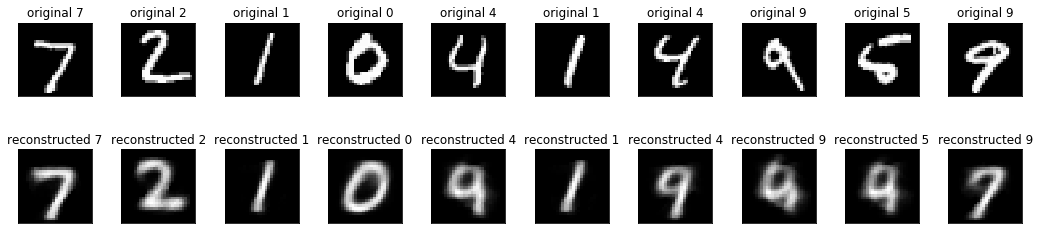

Model saved in path: ./VAE-model.ckpt
At epoch 7, ELBO: training: 39.5440, test: 36.9899; 
reconstruction error: training: 35.0887, test: 32.5345; 
KL loss: training: 4.4552, test: 4.4555.


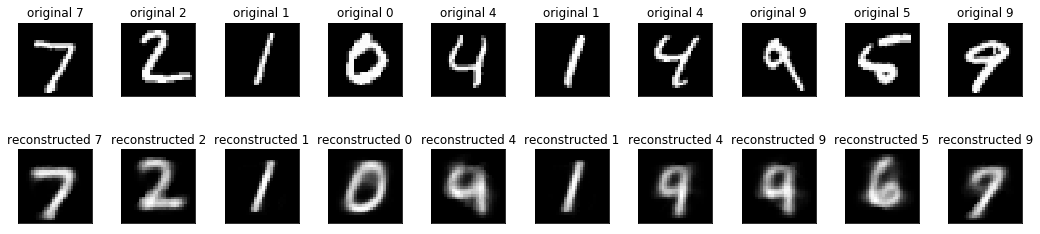

Model saved in path: ./VAE-model.ckpt
At epoch 8, ELBO: training: 36.6355, test: 35.3124; 
reconstruction error: training: 32.1691, test: 30.8948; 
KL loss: training: 4.4663, test: 4.4176.


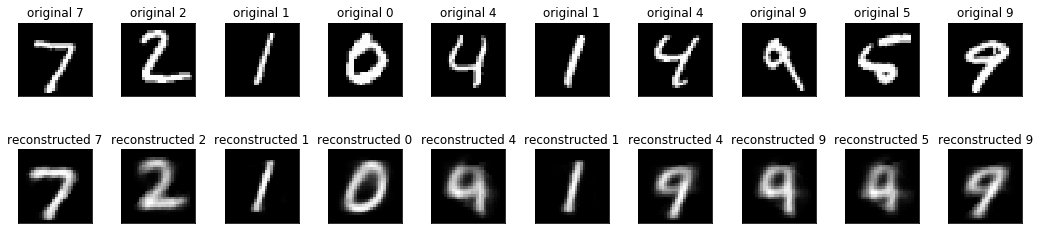

Model saved in path: ./VAE-model.ckpt
At epoch 9, ELBO: training: 36.7920, test: 35.6740; 
reconstruction error: training: 32.1340, test: 31.0252; 
KL loss: training: 4.6580, test: 4.6488.


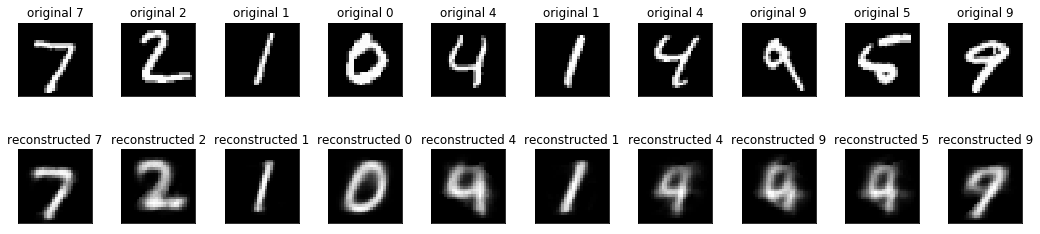

Model saved in path: ./VAE-model.ckpt


In [0]:
n_epoch = 10
train_elbo = []
train_reconstruction = []
train_KL = []
val_elbo = []
val_reconstruction = []
val_KL = []
n_train_iter = n_train // batch_size
for cur_epoch in range(n_epoch):
    sess.run(iterator.initializer,
             feed_dict={input_image: np.expand_dims(x_train, -1),
                        input_label: np.expand_dims(y_train, -1),
                        seed: cur_epoch})
    # training stage
    for i in range(n_train_iter):
        training_image, training_label = sess.run([batch_image, batch_label])
        feed_dict = {input_image: training_image,
                     input_label: training_label,
                     is_code_input: False,
                     code_input: np.zeros((batch_size, code_size))}
        elbo_train, train_res, train_kl, _ = sess.run([elbo, reconstruction_loss, KL_loss, train_step], feed_dict=feed_dict)
        train_elbo.append(elbo_train)
        train_reconstruction.append(train_res)
        train_KL.append(train_kl)
    
    # validation stage
    feed_dict = {input_image: np.expand_dims(x_test[:10], -1),
                 input_label: np.expand_dims(y_test[:10], -1),
                 is_code_input: False,
                 code_input: np.zeros((10, code_size))}
    elbo_val, res_val, kl_val, reconstructed_image = sess.run([elbo, reconstruction_loss, KL_loss, decoded_image], feed_dict=feed_dict)
    val_elbo.append(elbo_val)
    val_reconstruction.append(res_val)
    val_KL.append(kl_val)
    print("At epoch {}, ELBO: training: {:.4f}, test: {:.4f}; \nreconstruction error: training: {:.4f}, test: {:.4f}; \nKL loss: training: {:.4f}, test: {:.4f}.".format(cur_epoch, elbo_train, elbo_val, train_res, res_val, train_kl, kl_val))
    plot_reconstructed_signal(x_test, y_test, reconstructed_image)
    
    # save the trained model
    saved_model_name = "./VAE-model.ckpt"
    save_path = saver.save(sess, saved_model_name)
    print("Model saved in path: {}".format(save_path))

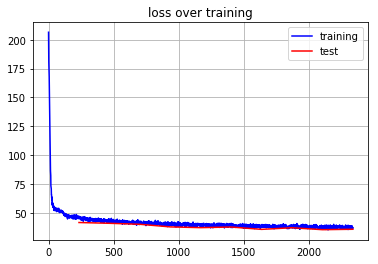

In [0]:
# plot training and test error
plt.plot(train_elbo, 'b-')
plt.plot(n_train_iter * np.arange(1, n_epoch+1, 1), val_elbo, 'r-')
plt.grid(True)
plt.title('loss over training')
plt.legend(('training', 'test'))
plt.show()

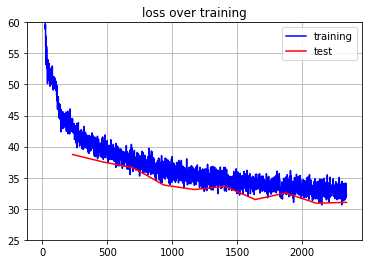

In [0]:
# plot training and test error
plt.plot(train_reconstruction, 'b-')
plt.plot(n_train_iter * np.arange(1, n_epoch+1, 1), val_reconstruction, 'r-')
plt.grid(True)
plt.ylim([25,60])
plt.title('loss over training')
plt.legend(('training', 'test'))
plt.show()

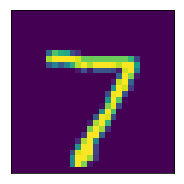

In [0]:
figure(figsize=(3,3))
plt.imshow(x_test[0])
plt.xticks([])
plt.yticks([])
plt.show()

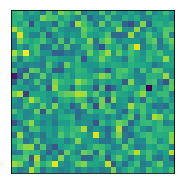

[ 0.48555639  0.82308489 -0.63095515  0.30356508 -0.16748443 -0.98946803
  0.97599913 -0.78491255  1.47424626  0.94342462]


In [0]:
noise = np.random.normal(loc=0., scale=1., size=28*28)
noise = np.reshape(noise, (28,28))
figure(figsize=(3,3))
plt.imshow(noise)
plt.xticks([])
plt.yticks([])
plt.show()
print(noise[0,:10])

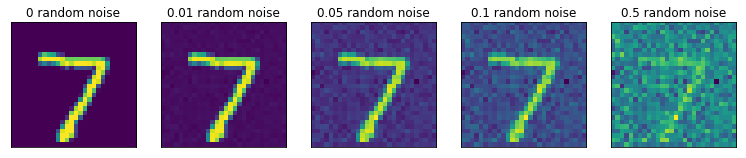

In [0]:
fig, axs = plt.subplots(1, 5, figsize=(13, 3), edgecolor='k')
axs = axs.ravel()
noise_amp = (0, 0.01, 0.05, 0.1, 0.5)
for i in range(5):
  axs[i].imshow(noise_amp[i]*noise+x_test[0])
  axs[i].set_xticks([])
  axs[i].set_yticks([])
  axs[i].set_title("{} random noise".format(noise_amp[i]))
plt.show()

In [0]:
# compute the embedding of the perturbed x_test[0] image
x_perturbed_0 = np.zeros((5,28,28))
for i in range(5):
  x_perturbed_0[i] = x_test[0] + noise_amp[i]*noise
  
feed_dict = {input_image: np.expand_dims(x_perturbed_0, -1),
             input_label: np.expand_dims(y_test[:5], -1),
             is_code_input: False,
             code_input: np.zeros((5, code_size))}
encoded_code_perturbed = sess.run(encoded_code, feed_dict = feed_dict)
print(encoded_code_perturbed.shape)
print(encoded_code_perturbed)

(5, 2)
[[-1.9403262  1.2506145]
 [-1.9199114  1.2420999]
 [-1.8436052  1.2073717]
 [-1.7835585  1.1832482]
 [-1.7673801  0.838506 ]]


[[ 0.02041483 -0.00851464]
 [ 0.09672105 -0.04324281]
 [ 0.15676773 -0.06736636]
 [ 0.1729461  -0.41210854]]


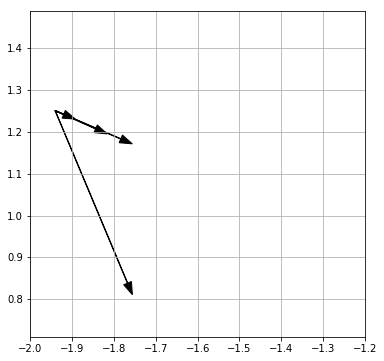

In [0]:
# visualise the change in the code space
diff_code = encoded_code_perturbed[1:] - encoded_code_perturbed[0]
print(diff_code)

figure(figsize=(6,6))
# P.arrow( x, y, dx, dy, **kwargs )
for i in range(4):
  plt.arrow( encoded_code_perturbed[0,0], encoded_code_perturbed[0,1], diff_code[i,0], diff_code[i,1], fc="k", ec="k", head_width=0.02, head_length=0.03 )
plt.axis('equal')
plt.axis((-2.,-1.2,0.7,1.5))
plt.grid(True)
plt.show()